<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription_(34).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- Configuration Parameters ---
N = 128                      # Block length
K = 64                       # Info bits
CRC_LEN = 8                  # CRC bits
L_list = [1, 4, 8, 16]       # SCL list sizes
TOTAL_BITS = K + CRC_LEN
SNR_DB_RANGE = np.arange(0.0, 4.5, 0.5)
NUM_FRAMES = 80000

# RNN Training Config
EPOCHS = 50
BATCH_SIZE = 128
TRAIN_SNR_DB = 2.0
VAL_SNR_DB = 2.0
LEARNING_RATE = 1e-3

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- CRC-8 Polynomial: x^8 + x^2 + x + 1 ---
CRC_POLY = 0x07

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# --- Polar Reliability (5G 128-bit) ---
polar_reliability_sequence = list(range(128))  # placeholder; replace with actual 5G sequence
info_indices = sorted(polar_reliability_sequence[:TOTAL_BITS])
frozen_indices = sorted(set(range(N)) - set(info_indices))

# --- Polar Transform ---
def polar_transform(u):
    u = u.copy()
    n = int(np.log2(len(u)))
    for d in range(n):
        step = 2 ** d
        for i in range(0, len(u), 2 * step):
            for j in range(step):
                u[i + j] ^= u[i + j + step]
    return u

# --- Encoder ---
def polar_encode(info_bits):
    u = np.zeros(N, dtype=int)
    info_crc = crc_encode(info_bits)
    u[info_indices] = info_crc
    return polar_transform(u)

# --- Channel + LLR ---
def bpsk(x): return 1 - 2 * x

def awgn(y, snr_db):
    snr = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr))
    noise = sigma * np.random.randn(*y.shape)
    return y + noise, sigma

def llr_calc(y, sigma):
    return 2 * y / (sigma ** 2)

def compute_mutual_information(llrs, bits):
    llrs = np.clip(llrs, -50, 50)
    mi = 1 - np.mean(np.log2(1 + np.exp(-llrs * (1 - 2 * bits))))
    return mi

# --- Dataset generation ---
def generate_dataset(num_frames, snr_db):
    inputs = []
    targets = []
    for _ in range(num_frames):
        info_bits = np.random.randint(0, 2, K)
        encoded = polar_encode(info_bits)
        tx_signal = bpsk(encoded)
        rx_signal, sigma = awgn(tx_signal, snr_db)
        llrs = llr_calc(rx_signal, sigma)
        inputs.append(llrs)
        targets.append(info_bits)
    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32)
    return TensorDataset(inputs, targets)

# --- Fast SSC Decoder ---
def f_func(a, b):
    return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

def g_func(a, b, c):
    return b + (1 - 2 * c) * a

def fast_ssc_decode(llrs, frozen_indices):
    N = len(llrs)
    is_frozen = np.zeros(N, dtype=bool)
    is_frozen[frozen_indices] = True

    def recurse(llr, frozen_mask):
        length = len(llr)
        if length == 1:
            return np.array([0]) if frozen_mask[0] else np.array([0 if llr[0] >= 0 else 1])

        if np.all(frozen_mask):
            return np.zeros(length, dtype=int)

        if not np.any(frozen_mask):
            return np.array([0 if l >= 0 else 1 for l in llr])

        if np.all(frozen_mask[:-1]) and not frozen_mask[-1]:
            total_llr = np.sum(llr)
            bit = 0 if total_llr >= 0 else 1
            return np.concatenate([np.zeros(length - 1, dtype=int), [bit]])

        if frozen_mask[0] and not np.any(frozen_mask[1:]):
            bits = np.array([0 if l >= 0 else 1 for l in llr])
            parity = np.sum(bits) % 2
            if parity != 0:
                min_index = np.argmin(np.abs(llr))
                bits[min_index] ^= 1
            return bits

        half = length // 2
        llr_left = f_func(llr[:half], llr[half:])
        u_left = recurse(llr_left, frozen_mask[:half])
        llr_right = g_func(llr[:half], llr[half:], u_left)
        u_right = recurse(llr_right, frozen_mask[half:])
        return np.concatenate([u_left, u_right])

    return recurse(llrs, is_frozen)

# --- Fast SC Decoder ---
def fast_sc_decode(llr, frozen_indices):
    N = len(llr)
    frozen_set = set(frozen_indices)
    u_hat = np.zeros(N, dtype=int)

    def recurse(llr, depth, offset):
        if depth == 0:
            index = offset
            if index in frozen_set:
                return np.array([0])
            else:
                return np.array([int(llr[0] < 0)])

        half = len(llr) // 2
        l0 = f_func(llr[:half], llr[half:])
        u0 = recurse(l0, depth - 1, offset)
        l1 = g_func(llr[:half], llr[half:], u0)
        u1 = recurse(l1, depth - 1, offset + half)
        return np.concatenate([u0, u1])

    depth = int(np.log2(N))
    return recurse(llr, depth, 0)

# --- Fast SCL Decoder ---
def fast_scl_decode(llr, frozen_indices, L):
    paths = [(np.zeros(len(llr), dtype=int), 0.0)]
    frozen_set = set(frozen_indices)

    for i in range(len(llr)):
        new_paths = []
        for u_prev, pm in paths:
            if i in frozen_set:
                u = u_prev.copy()
                u[i] = 0
                pm_new = pm + (0 if llr[i] >= 0 else abs(llr[i]))
                new_paths.append((u, pm_new))
            else:
                for bit in [0, 1]:
                    u = u_prev.copy()
                    u[i] = bit
                    pm_new = pm + (0 if bit == (llr[i] < 0) else abs(llr[i]))
                    new_paths.append((u, pm_new))
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:L]

    for u, _ in paths:
        decoded = polar_transform(u)
        if crc_check(decoded[info_indices]):
            return u

    return paths[0][0]

# --- RNN Decoder ---
class PolarRNNDecoder(nn.Module):
    def __init__(self, input_size=N, hidden_size=256, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, K)

    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: (batch, N, 1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out  # raw logits for BCEWithLogitsLoss

# --- Training and Validation Dataset ---
def generate_data(num_samples, snr_db):
    X, Y = [], []
    for _ in range(num_samples):
        info = np.random.randint(0, 2, K)
        x = polar_encode(info)
        y = bpsk(x)
        y_noisy, sigma = awgn(y, snr_db)
        llr = llr_calc(y_noisy, sigma)
        X.append(llr)
        Y.append(info)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# --- Training Function ---
def train_rnn(model, train_loader, val_loader, criterion, optimizer):
    train_losses, val_losses = [], []
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
    return train_losses, val_losses

# --- Plotting Functions ---
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('RNN Training/Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_sc_decoder(snr_range, ber_sc, bler_sc):
    plt.figure(figsize=(8, 5))
    plt.semilogy(snr_range, ber_sc, 'o-', label='SC BER')
    plt.semilogy(snr_range, bler_sc, 's--', label='SC BLER')
    plt.ylim(1e-5, 1e0)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('SC Decoder: BER and BLER vs SNR')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scl_decoder(snr_range, ber_scl_dict, bler_scl_dict):
    plt.figure(figsize=(8, 5))
    for L in ber_scl_dict:
        plt.semilogy(snr_range, ber_scl_dict[L], marker='o', label=f'SCL L={L} BER')
    for L in bler_scl_dict:
        plt.semilogy(snr_range, bler_scl_dict[L], marker='s', linestyle='--', label=f'SCL L={L} BLER')
    plt.ylim(1e-5, 1e0)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('SCL Decoder: BER and BLER vs SNR')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_rnn_decoder(snr_range, ber_rnn, bler_rnn):
    plt.figure(figsize=(8, 5))
    plt.semilogy(snr_range, ber_rnn, 'o-', label='RNN BER')
    plt.semilogy(snr_range, bler_rnn, 's--', label='RNN BLER')
    plt.ylim(1e-5, 1e0)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('RNN Decoder: BER and BLER vs SNR')
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Main function ---
def main():
    print(f"Running on device: {DEVICE}")

    # Prepare RNN model, optimizer, loss
    rnn_model = PolarRNNDecoder().to(DEVICE)
    optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # Generate dataset
    trainval_dataset = generate_dataset(NUM_FRAMES, TRAIN_SNR_DB)
    train_size = int(0.8 * len(trainval_dataset))
    val_size = len(trainval_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Train RNN
    train_losses, val_losses = train_rnn(rnn_model, train_loader, val_loader, criterion, optimizer)
    plot_loss(train_losses, val_losses)

    # Evaluate decoders over SNR range
    ber_sc, bler_sc = [], []
    ber_rnn, bler_rnn = [], []
    ber_scl_dict = {L: [] for L in L_list}
    bler_scl_dict = {L: [] for L in L_list}
    mi_vals = []

    for snr_db in SNR_DB_RANGE:
        print(f"Simulating SNR={snr_db:.1f} dB")
        bit_errors_sc = 0
        block_errors_sc = 0
        bit_errors_rnn = 0
        block_errors_rnn = 0
        bit_errors_scl = {L: 0 for L in L_list}
        block_errors_scl = {L: 0 for L in L_list}
        mi_accum = []

        for _ in range(NUM_FRAMES):
            info_bits = np.random.randint(0, 2, K)
            encoded = polar_encode(info_bits)
            tx_signal = bpsk(encoded)
            rx_signal, sigma = awgn(tx_signal, snr_db)
            llrs = llr_calc(rx_signal, sigma)

            mi_accum.append(compute_mutual_information(llrs[info_indices], info_bits))

            # SC decode
            sc_u_hat = fast_ssc_decode(llrs, frozen_indices)
            sc_bits_hat = polar_transform(sc_u_hat)[info_indices][:TOTAL_BITS]
            sc_info_hat = sc_bits_hat[:K]
            err_bits_sc = np.sum(sc_info_hat != info_bits)
            bit_errors_sc += err_bits_sc
            if err_bits_sc > 0:
                block_errors_sc += 1

            # RNN decode
            llr_tensor = torch.tensor(llrs, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(DEVICE)
            rnn_model.eval()
            with torch.no_grad():
                rnn_output = rnn_model(llr_tensor).cpu().numpy().flatten()
            rnn_info_hat = (rnn_output > 0).astype(int)
            err_bits_rnn = np.sum(rnn_info_hat[:K] != info_bits)
            bit_errors_rnn += err_bits_rnn
            if err_bits_rnn > 0:
                block_errors_rnn += 1

            # SCL decode
            for L in L_list:
                scl_u_hat = fast_scl_decode(llrs, frozen_indices, L)
                scl_bits_hat = polar_transform(scl_u_hat)[info_indices][:TOTAL_BITS]
                scl_info_hat = scl_bits_hat[:K]
                err_bits_scl = np.sum(scl_info_hat != info_bits)
                bit_errors_scl[L] += err_bits_scl
                if err_bits_scl > 0:
                    block_errors_scl[L] += 1

        ber_sc.append(bit_errors_sc / (NUM_FRAMES * K))
        bler_sc.append(block_errors_sc / NUM_FRAMES)
        ber_rnn.append(bit_errors_rnn / (NUM_FRAMES * K))
        bler_rnn.append(block_errors_rnn / NUM_FRAMES)
        for L in L_list:
            ber_scl_dict[L].append(bit_errors_scl[L] / (NUM_FRAMES * K))
            bler_scl_dict[L].append(block_errors_scl[L] / NUM_FRAMES)

        mi_vals.append(np.mean(mi_accum))

        print(f"SNR={snr_db:.1f} | SC BER={ber_sc[-1]:.2e}, BLER={bler_sc[-1]:.2e} | "
              f"RNN BER={ber_rnn[-1]:.2e}, BLER={bler_rnn[-1]:.2e} | " +
              " | ".join([f"SCL L={L} BER={ber_scl_dict[L][-1]:.2e}, BLER={bler_scl_dict[L][-1]:.2e}" for L in L_list])
        )

    # Plot BER/BLER curves separately
    plot_sc_decoder(SNR_DB_RANGE, ber_sc, bler_sc)
    plot_rnn_decoder(SNR_DB_RANGE, ber_rnn, bler_rnn)
    plot_scl_decoder(SNR_DB_RANGE, ber_scl_dict, bler_scl_dict)

    # Plot Mutual Information
    plt.figure(figsize=(8,5))
    plt.plot(SNR_DB_RANGE, mi_vals, marker='o', label='Mutual Information')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Mutual Information (bits)')
    plt.title('Mutual Information vs SNR')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()

Using device: cuda
Running on device: cuda
Epoch 1: Train Loss = 0.6934, Val Loss = 0.6933
Epoch 2: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 3: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 4: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 5: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 6: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 7: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 8: Train Loss = 0.6932, Val Loss = 0.6932
Epoch 9: Train Loss = 0.6915, Val Loss = 0.6892
Epoch 10: Train Loss = 0.6876, Val Loss = 0.6861
Epoch 11: Train Loss = 0.6847, Val Loss = 0.6839
Epoch 12: Train Loss = 0.6825, Val Loss = 0.6818
Epoch 13: Train Loss = 0.6798, Val Loss = 0.6814
Epoch 14: Train Loss = 0.6759, Val Loss = 0.6800
Epoch 15: Train Loss = 0.6711, Val Loss = 0.6686
Epoch 16: Train Loss = 0.6658, Val Loss = 0.6675
Epoch 17: Train Loss = 0.6606, Val Loss = 0.6600
Epoch 18: Train Loss = 0.6567, Val Loss = 0.6581
Epoch 19: Train Loss = 0.6760, Val Loss = 0.6809
Epoch 20: Train Loss = 0.6677, Val 

KeyboardInterrupt: 

Using device: cuda
Running on device: cuda
Epoch 1: Train Loss = 0.6932, Val Loss = 0.6931
Epoch 2: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 3: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 4: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 5: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 6: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 7: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 8: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 9: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 10: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 11: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 12: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 13: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 14: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 15: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 16: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 17: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 18: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 19: Train Loss = 0.6931, Val Loss = 0.6931
Epoch 20: Train Loss = 0.6931, Val 

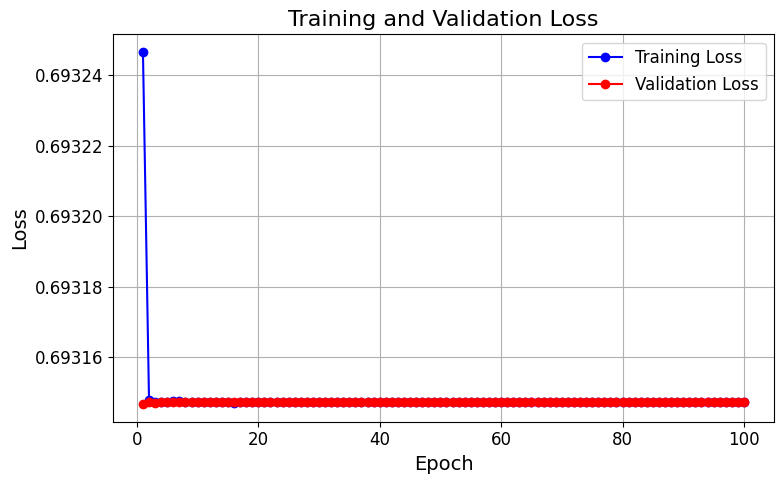

Simulating SNR=-0.5 dB


KeyboardInterrupt: 

In [19]:
# Unified Polar Code Simulation Script
# Includes: SC, CRC-aided SCL, RNN Decoder (GPU-enabled), BER/BLER + MI Plots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# --- Configuration Parameters ---
N = 128                      # Block length
K = 64                       # Info bits
CRC_LEN = 8                  # CRC bits
L_list = [1, 4, 8, 16]       # SCL list sizes
TOTAL_BITS = K + CRC_LEN
SNR_DB_RANGE = np.arange(-0.5, 4.5, 0.5)
NUM_FRAMES = 140000

# RNN Training Config
EPOCHS = 100
BATCH_SIZE = 128
TRAIN_SNR_DB = 2.0
VAL_SNR_DB = 2.0
LEARNING_RATE = 1e-3

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- CRC-8 Polynomial: x^8 + x^2 + x + 1 ---
CRC_POLY = 0x07

def crc_encode(info_bits):
    data = np.concatenate([info_bits, np.zeros(CRC_LEN, dtype=int)])
    for i in range(len(info_bits)):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.concatenate([info_bits, data[-CRC_LEN:]])

def crc_check(codeword):
    data = codeword.copy()
    for i in range(len(codeword) - CRC_LEN):
        if data[i] == 1:
            for j in range(CRC_LEN + 1):
                if ((CRC_POLY >> j) & 1):
                    data[i + j] ^= 1
    return np.all(data[-CRC_LEN:] == 0)

# --- Polar Reliability (5G 128-bit) ---
polar_reliability_sequence = list(range(128))  # placeholder; replace with actual 5G sequence
info_indices = sorted(polar_reliability_sequence[:TOTAL_BITS])
frozen_indices = sorted(set(range(N)) - set(info_indices))

# --- Polar Transform ---
def polar_transform(u):
    u = u.copy()
    n = int(np.log2(len(u)))
    for d in range(n):
        step = 2 ** d
        for i in range(0, len(u), 2 * step):
            for j in range(step):
                u[i + j] ^= u[i + j + step]
    return u

# --- Encoder ---
def polar_encode(info_bits):
    u = np.zeros(N, dtype=int)
    info_crc = crc_encode(info_bits)
    u[info_indices] = info_crc
    return polar_transform(u)

# --- Channel + LLR ---
def bpsk(x): return 1 - 2 * x

def awgn(y, snr_db):
    snr = 10 ** (snr_db / 10)
    sigma = np.sqrt(1 / (2 * snr))
    noise = sigma * np.random.randn(*y.shape)
    return y + noise, sigma

def llr_calc(y, sigma):
    return 2 * y / (sigma ** 2)

def compute_mutual_information(llrs, bits):
    # Align bits length with llrs length to avoid broadcasting errors
    bits = bits[:len(llrs)]
    llrs = np.clip(llrs, -50, 50)
    mi = 1 - np.mean(np.log2(1 + np.exp(-llrs * (1 - 2 * bits))))
    return mi


def generate_dataset(num_frames, snr_db):
    inputs = []
    targets = []
    for _ in range(num_frames):
        info_bits = np.random.randint(0, 2, K)
        encoded = polar_encode(info_bits)
        tx_signal = bpsk(encoded)
        rx_signal, sigma = awgn(tx_signal, snr_db)
        llrs = llr_calc(rx_signal, sigma)

        inputs.append(llrs)
        targets.append(info_bits)
    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32)
    return TensorDataset(inputs, targets)

def fast_ssc_decode(llrs, frozen_indices):
    N = len(llrs)
    u_hat = np.zeros(N, dtype=int)
    is_frozen = np.zeros(N, dtype=bool)
    is_frozen[frozen_indices] = True

    def recurse(llr, start, length, frozen_mask):
        if length == 1:
            return np.array([0]) if frozen_mask[0] else np.array([0 if llr[0] >= 0 else 1])

        # Rate-0 node (all frozen)
        if np.all(frozen_mask):
            return np.zeros(length, dtype=int)

        # Rate-1 node (all info)
        if not np.any(frozen_mask):
            return np.array([0 if l >= 0 else 1 for l in llr])

        # Repetition node (only last bit is info)
        if np.all(frozen_mask[:-1]) and not frozen_mask[-1]:
            total_llr = np.sum(llr)
            bit = 0 if total_llr >= 0 else 1
            return np.concatenate([np.zeros(length - 1, dtype=int), [bit]])

        # SPC node (only first bit is frozen)
        if frozen_mask[0] and not np.any(frozen_mask[1:]):
            bits = np.array([0 if l >= 0 else 1 for l in llr])
            parity = np.sum(bits) % 2
            if parity != 0:
                # Flip the LSB with least reliable LLR
                min_index = np.argmin(np.abs(llr))
                bits[min_index] ^= 1
            return bits

        # Recursive case: split into halves
        half = length // 2
        llr_left = f_func(llr[:half], llr[half:])
        u_left = recurse(llr_left, start, half, frozen_mask[:half])

        llr_right = g_func(llr[:half], llr[half:], u_left)
        u_right = recurse(llr_right, start + half, half, frozen_mask[half:])

        return np.concatenate([u_left, u_right])

    # f and g node operations
    def f_func(a, b):
        return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

    def g_func(a, b, c):
        return b + (1 - 2 * c) * a

    u_hat = recurse(llrs, 0, N, is_frozen)
    return u_hat

################################################################################
# Fast SC Decoder functions
def f(a, b):
    return np.sign(a) * np.sign(b) * np.minimum(np.abs(a), np.abs(b))

def g(a, b, c):
    return b + (1 - 2 * c) * a

def fast_sc_decode(llr, frozen_indices):
    N = len(llr)
    u_hat = np.zeros(N, dtype=int)

    def recurse(llr, depth, offset):
        if depth == 0:
            index = offset
            if index in frozen_indices:
                return np.array([0])
            else:
                return np.array([int(llr[0] < 0)])

        half = len(llr) // 2
        l0 = f(llr[:half], llr[half:])
        u0 = recurse(l0, depth - 1, offset)
        l1 = g(llr[:half], llr[half:], u0)
        u1 = recurse(l1, depth - 1, offset + half)
        return np.concatenate([u0, u1])

    depth = int(np.log2(N))
    return recurse(llr, depth, 0)

################################################################################
# Fast CRC-Aided SCL Decoder (simple path metric based)
def fast_scl_decode(llr, frozen_indices, L):
    paths = [(np.zeros(len(llr), dtype=int), 0.0)]

    for i in range(len(llr)):
        new_paths = []
        for u_prev, pm in paths:
            if i in frozen_indices:
                u = u_prev.copy()
                u[i] = 0
                pm_new = pm + (0 if llr[i] >= 0 else abs(llr[i]))
                new_paths.append((u, pm_new))
            else:
                for bit in [0, 1]:
                    u = u_prev.copy()
                    u[i] = bit
                    pm_new = pm + (0 if bit == (llr[i] < 0) else abs(llr[i]))
                    new_paths.append((u, pm_new))
        new_paths.sort(key=lambda x: x[1])
        paths = new_paths[:L]

    for u, _ in paths:
        decoded = polar_transform(u)
        if crc_check(decoded[info_indices]):
            return u

    return paths[0][0]

################################################################################
# Tuned RNN
# --- RNN Decoder (Tuned) ---
class PolarRNNDecoder(nn.Module):
    def __init__(self, input_size=N, hidden_size=512, num_layers=3):
        super().__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, K)

    def forward(self, x):
        x = x.unsqueeze(-1)  # shape: (batch, N, 1)
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

# --- Training Function (unchanged, uses updated model and dataset) ---
#def train_rnn(model, train_loader, val_loader, criterion, optimizer):
def train_rnn(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                outputs = model(xb)
                val_loss += criterion(outputs, yb).item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")
    return train_losses, val_losses
#################################################################################
# RNN Decoder (Simple GRU)
def generate_dataset(num_frames, snr_db_or_range):
    inputs = []
    targets = []

    for _ in range(num_frames):
        info_bits = np.random.randint(0, 2, K)

        encoded = polar_encode(info_bits)
        tx_signal = bpsk(encoded)

        # Support either single SNR or a range
        if isinstance(snr_db_or_range, (list, np.ndarray)):
            snr_db = np.random.choice(snr_db_or_range)
        else:
            snr_db = snr_db_or_range

        rx_signal, sigma = awgn(tx_signal, snr_db)
        llrs = llr_calc(rx_signal, sigma)

        inputs.append(llrs)
        targets.append(info_bits)

    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32)
    return TensorDataset(inputs, targets)



# CSV file saving
def save_ber_bler_csv(snr_range, ber_dict, bler_dict, filename="ber_bler_results.csv"):
    data = {"SNR(dB)": snr_range}
    for label, ber in ber_dict.items():
        data[f"{label}_BER"] = ber
    for label, bler in bler_dict.items():
        data[f"{label}_BLER"] = bler
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"[✓] Saved BER/BLER results to: {filename}")
####################################################################
# Latest Plotting Functions



# Ensure plot uses correct font and styles
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': (10, 6),
    'axes.grid': True
})
##################################################################################################################

def plot_ber(snr_range, ber_results, title):
    plt.figure(figsize=(8, 5))
    for label, ber in ber_results.items():
        plt.semilogy(snr_range, ber, marker='o', label=label)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Bit Error Rate (BER)')
    plt.title(title)
    plt.ylim(1e-5, 1)
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_bler(snr_range, bler_results, title):
    plt.figure(figsize=(8, 5))
    for label, bler in bler_results.items():
        plt.semilogy(snr_range, bler, marker='s', label=label)
    plt.xlabel('SNR (dB)')
    plt.ylabel('Block Error Rate (BLER)')
    plt.title(title)
    plt.ylim(1e-5, 1)
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_training_validation_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_mutual_information(snr_range, mi_values):
    plt.figure(figsize=(8, 5))
    plt.plot(snr_range, mi_values, 'g-o', label='Mutual Information')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Mutual Information (bits)')
    plt.title('Mutual Information vs. SNR')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    print(f"Running on device: {DEVICE}")

    # --- Configuration ---
    NUM_FRAMES = 140000
    EPOCHS = 100
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    TRAIN_SNR_RANGE = np.arange(0.5, 4.5, 0.5)
    SNR_DB_RANGE = np.arange(-0.5, 4.5, 0.5)
    L_list = [1, 4, 8, 16]

    # Initialize RNN model, optimizer, and loss function
    rnn_model = PolarRNNDecoder().to(DEVICE)
    optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    # Generate datasets and loaders
    trainval_dataset = generate_dataset(NUM_FRAMES, TRAIN_SNR_RANGE)
    train_size = int(0.8 * len(trainval_dataset))
    val_size = len(trainval_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Train RNN and plot training/validation loss
    train_losses, val_losses = train_rnn(rnn_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)
   # train_losses, val_losses = train_rnn(rnn_model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)
    plot_training_validation_loss(train_losses, val_losses)

    # Initialize results containers
    ber_sc, bler_sc = [], []
    ber_rnn, bler_rnn = [], []
    ber_scl_dict = {L: [] for L in L_list}
    bler_scl_dict = {L: [] for L in L_list}
    mi_vals = []

    # Evaluate decoders over SNR range
    for snr_db in SNR_DB_RANGE:
        print(f"Simulating SNR={snr_db:.1f} dB")
        bit_errors_sc = 0
        block_errors_sc = 0
        bit_errors_rnn = 0
        block_errors_rnn = 0
        bit_errors_scl = {L: 0 for L in L_list}
        block_errors_scl = {L: 0 for L in L_list}
        mi_accum = []

        for _ in range(NUM_FRAMES):
            info_bits = np.random.randint(0, 2, K)
            encoded = polar_encode(info_bits)
            tx_signal = bpsk(encoded)
            rx_signal, sigma = awgn(tx_signal, snr_db)
            llrs = llr_calc(rx_signal, sigma)

            mi_accum.append(compute_mutual_information(llrs[info_indices], crc_encode(info_bits)))

            # SC decoding
            sc_u_hat = fast_ssc_decode(llrs, frozen_indices)
            sc_bits_hat = polar_transform(sc_u_hat)[info_indices][:TOTAL_BITS]
            sc_info_hat = sc_bits_hat[:K]
            err_bits_sc = np.sum(sc_info_hat != info_bits)
            bit_errors_sc += err_bits_sc
            if err_bits_sc > 0:
                block_errors_sc += 1

            # RNN decoding
            llr_tensor = torch.tensor(llrs, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            rnn_model.eval()
            with torch.no_grad():
                rnn_output = rnn_model(llr_tensor).cpu().numpy().flatten()
            rnn_info_hat = (rnn_output > 0.5).astype(int)
            err_bits_rnn = np.sum(rnn_info_hat[:K] != info_bits)
            bit_errors_rnn += err_bits_rnn
            if err_bits_rnn > 0:
                block_errors_rnn += 1

            # SCL decoding for each list size
            for L in L_list:
                scl_u_hat = fast_scl_decode(llrs, frozen_indices, L)
                scl_bits_hat = polar_transform(scl_u_hat)[info_indices][:TOTAL_BITS]
                scl_info_hat = scl_bits_hat[:K]
                err_bits_scl = np.sum(scl_info_hat != info_bits)
                bit_errors_scl[L] += err_bits_scl
                if err_bits_scl > 0:
                    block_errors_scl[L] += 1

        # Append results for this SNR
        ber_sc.append(bit_errors_sc / (NUM_FRAMES * K))
        bler_sc.append(block_errors_sc / NUM_FRAMES)
        ber_rnn.append(bit_errors_rnn / (NUM_FRAMES * K))
        bler_rnn.append(block_errors_rnn / NUM_FRAMES)
        for L in L_list:
            ber_scl_dict[L].append(bit_errors_scl[L] / (NUM_FRAMES * K))
            bler_scl_dict[L].append(block_errors_scl[L] / NUM_FRAMES)
        mi_vals.append(np.mean(mi_accum))

        print(f"SNR={snr_db:.1f} | SC BER={ber_sc[-1]:.2e}, BLER={bler_sc[-1]:.2e} | "
              f"RNN BER={ber_rnn[-1]:.2e}, BLER={bler_rnn[-1]:.2e} | " +
              " | ".join([f"SCL L={L} BER={ber_scl_dict[L][-1]:.2e}, BLER={bler_scl_dict[L][-1]:.2e}" for L in L_list]))

    # Organize results for plotting
    ber_results_sc = {"SC": ber_sc}
    bler_results_sc = {"SC": bler_sc}
    ber_results_scl = {f"L={L}": ber_scl_dict[L] for L in L_list if L != 1}  # SCL excludes SC (L=1)
    bler_results_scl = {f"L={L}": bler_scl_dict[L] for L in L_list if L != 1}
    ber_results_rnn = {"RNN": ber_rnn}
    bler_results_rnn = {"RNN": bler_rnn}

    # Plot BER & BLER separately for SC, SCL, and RNN
    plot_ber(SNR_DB_RANGE, ber_results_sc, title="BER vs SNR SC")
    plot_bler(SNR_DB_RANGE, bler_results_sc, title="BLER vs SNR SC")

    plot_ber(SNR_DB_RANGE, ber_results_scl, title="BER vs SNR SCL")
    plot_bler(SNR_DB_RANGE, bler_results_scl, title="BLER vs SNR SCL")

    plot_ber(SNR_DB_RANGE, ber_results_rnn, title="BER vs SNR RNN")
    plot_bler(SNR_DB_RANGE, bler_results_rnn, title="BLER vs SNR RNN")

    # Plot Mutual Information
    plot_mutual_information(SNR_DB_RANGE, mi_vals)

if __name__ == "__main__":
    main()

###############################################################################################################



















